In [2]:
import pandas as pd
import numpy as np
import openpyxl
import torch
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, Dataset,Subset
from scipy.optimize import minimize

In [25]:
file_path = 'train_set.xlsx'
data_train = pd.read_excel(file_path)

In [26]:
file_path = 'val_set.xlsx'
data_val = pd.read_excel(file_path)

In [27]:
file_path = 'test_set.xlsx'
data_test = pd.read_excel(file_path)

In [28]:
x_test = data_test.iloc[:, 5:]
temperature_test = data_test['temperature,oc'].values
fre_test = data_test['frequency,Hz'].values
c_loss_test = data_test['core loss,w/m3'].values
material_test = data_test['material type'].values
wavetype_test = data_test['excitation waveform'].values

x_val = data_val.iloc[:, 5:]
temperature_test = data_val['temperature,oc'].values
fre_test = data_val['frequency,Hz'].values
c_loss_test = data_val['core loss,w/m3'].values
material_test = data_val['material type'].values
wavetype_test = data_val['excitation waveform'].values

x_train = data_train.iloc[:, 5:]
temperature_test = data_train['temperature,oc'].values
fre_test = data_train['frequency,Hz'].values
c_loss_test = data_train['core loss,w/m3'].values
material_test = data_train['material type'].values
wavetype_test = data_train['excitation waveform'].values

In [29]:
sample_new=[]

mean=[]
max_val=[]
min_val=[]
std=[]
var=[]
ske=[]
kur=[]
rms=[]
sum=[]
ptp=[]
power=[]
smoothness=[]
maxpos=[]
minpos=[]

q1=[]
q2=[]
q3=[]

for i in range(len(x_train)):
    sample=x_train.iloc[i].to_numpy()
    max_position = np.argmax(sample)
    min_position = np.argmin(sample)

    signal=sample
    mean.append(np.mean(signal))          
    max_val.append(np.max(signal))        
    min_val.append(np.min(signal))        
    std.append(np.std(signal))            
    var.append(np.var(signal))            
    ske.append(skew(signal))              
    kur.append(kurtosis(signal))         
    rms.append(np.sqrt(np.mean(signal**2)))  
    sum.append(np.sum(signal))  
    ptp.append(np.ptp(signal))  
    power.append(np.mean(signal**2)) 
    smoothness.append(np.sqrt(np.mean(np.diff(signal))**2))
    maxpos.append(np.argmax(signal))
    minpos.append(np.argmin(signal))
    q1.append(np.percentile(signal, 25))
    q2.append(np.percentile(signal, 50)) 
    q3.append(np.percentile(signal, 75))
    
    sample_min = np.min(sample)
    sample_max = np.max(sample)
    sample_normalized = (sample-sample_min)/(sample_max-sample_min)
    sample_new.append(sample_normalized)

In [30]:
sample_new2=[]

mean2=[]
max_val2=[]
min_val2=[]
std2=[]
var2=[]
ske2=[]
kur2=[]
rms2=[]
sum2=[]
ptp2=[]
power2=[]
smoothness2=[]
maxpos2=[]
minpos2=[]

q12=[]
q22=[]
q32=[]

for i in range(len(x_val)):
    sample=x_val.iloc[i].to_numpy()
    max_position = np.argmax(sample)
    min_position = np.argmin(sample)

    signal=sample
    mean2.append(np.mean(signal))          
    max_val2.append(np.max(signal))        
    min_val2.append(np.min(signal))        
    std2.append(np.std(signal))           
    var2.append(np.var(signal))            
    ske2.append(skew(signal))             
    kur2.append(kurtosis(signal))          
    rms2.append(np.sqrt(np.mean(signal**2)))  
    sum2.append(np.sum(signal))  
    ptp2.append(np.ptp(signal))  
    power2.append(np.mean(signal**2)) 
    smoothness2.append(np.sqrt(np.mean(np.diff(signal))**2))
    maxpos2.append(np.argmax(signal))
    minpos2.append(np.argmin(signal))
    q12.append(np.percentile(signal, 25))
    q22.append(np.percentile(signal, 50)) 
    q32.append(np.percentile(signal, 75))
    
    sample_min = np.min(sample)
    sample_max = np.max(sample)
    sample_normalized = (sample-sample_min)/(sample_max-sample_min)
    sample_new2.append(sample_normalized)

In [31]:
sample_new3=[]

mean3=[]
max_val3=[]
min_val3=[]
std3=[]
var3=[]
ske3=[]
kur3=[]
rms3=[]
sum3=[]
ptp3=[]
power3=[]
smoothness3=[]
maxpos3=[]
minpos3=[]

q13=[]
q23=[]
q33=[]

for i in range(len(x_test)):
    sample=x_test.iloc[i].to_numpy()
    max_position = np.argmax(sample)
    min_position = np.argmin(sample)

    signal=sample
    mean3.append(np.mean(signal))          
    max_val3.append(np.max(signal))        
    min_val3.append(np.min(signal))      
    std3.append(np.std(signal))            
    var3.append(np.var(signal))          
    ske3.append(skew(signal))             
    kur3.append(kurtosis(signal))        
    rms3.append(np.sqrt(np.mean(signal**2)))  
    sum3.append(np.sum(signal))  
    ptp3.append(np.ptp(signal))  
    power3.append(np.mean(signal**2)) 
    smoothness3.append(np.sqrt(np.mean(np.diff(signal))**2))
    maxpos3.append(np.argmax(signal))
    minpos3.append(np.argmin(signal))
    q13.append(np.percentile(signal, 25))
    q23.append(np.percentile(signal, 50)) 
    q33.append(np.percentile(signal, 75))
    
    sample_min = np.min(sample)
    sample_max = np.max(sample)
    sample_normalized = (sample-sample_min)/(sample_max-sample_min)
    sample_new3.append(sample_normalized)

In [32]:
def compute_fft(signal):
    n = len(signal)
    fft_values = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, 1/fs)  
    return freq, np.abs(fft_values)
    
def get_amplitude_at_freq(freqs, fft_values, target_freq):
    idx = np.where(np.isclose(freqs, target_freq, atol=1e-1))[0]  
    if idx.size > 0:
        return fft_values[idx[0]]
    else:
        return None

In [33]:
fs=1024

fft_1=[]
fft_2=[]
fft_3=[]
fft_4=[]
fft_5=[]
spectral_centroid=[]
spectral_energy=[]
spectral_entropy=[]
spectral_peak=[]
dominant_frequency=[]
spectral_bandwidth=[]
spectral_slope=[]
spectral_flatness=[] 
energy_ratio_low = [] 
energy_ratio_mid = []  
energy_ratio_high = []  

for f in sample_new:
    frequencies, fft_values = compute_fft(f)
    f_1hz = get_amplitude_at_freq(frequencies, fft_values, 1)
    f_2hz = get_amplitude_at_freq(frequencies, fft_values, 2)
    f_3hz = get_amplitude_at_freq(frequencies, fft_values, 3)
    f_4hz = get_amplitude_at_freq(frequencies, fft_values, 4)
    f_5hz = get_amplitude_at_freq(frequencies, fft_values, 5)
    spectral_centroid1 = np.sum(frequencies * fft_values) / np.sum(fft_values)
    spectral_energy1 = np.sum(fft_values ** 2)
    normalized_spectrum = fft_values / np.sum(fft_values)
    spectral_entropy1 = -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-10))
    spectral_peak1 = np.max(fft_values)
    dominant_frequency1 = frequencies[np.argmax(fft_values)]
    spectral_bandwidth1 = np.sqrt(np.sum(((frequencies - spectral_centroid1) ** 2) * fft_values) / np.sum(fft_values))
    mean_amplitude = np.mean(fft_values)
    spectral_slope1 = np.sum(frequencies * (fft_values - mean_amplitude)) / np.sum(frequencies ** 2)
    spectral_flatness1 = np.exp(np.mean(np.log(fft_values + 1e-10))) / np.mean(fft_values)

    low_freq_mask = (frequencies >= 0) & (frequencies <= 10)
    mid_freq_mask = (frequencies > 10) & (frequencies <= 50)
    high_freq_mask = (frequencies > 50)

    low_energy_ratio = np.sum(fft_values[low_freq_mask] ** 2) / spectral_energy1
    mid_energy_ratio = np.sum(fft_values[mid_freq_mask] ** 2) / spectral_energy1
    high_energy_ratio = np.sum(fft_values[high_freq_mask] ** 2) / spectral_energy1
    
    energy_ratio_low.append(low_energy_ratio)
    energy_ratio_mid.append(mid_energy_ratio)
    energy_ratio_high.append(high_energy_ratio)    
    
    fft_1.append(f_1hz)
    fft_2.append(f_2hz)
    fft_3.append(f_3hz)
    fft_4.append(f_4hz)
    fft_5.append(f_5hz)
    spectral_centroid.append(spectral_centroid1)
    spectral_energy.append(spectral_energy1)
    spectral_entropy.append(spectral_entropy1)
    spectral_peak.append(spectral_peak1)
    dominant_frequency.append(dominant_frequency1)
    spectral_bandwidth.append(spectral_bandwidth1)
    spectral_slope.append(spectral_slope1)
    spectral_flatness.append(spectral_flatness1)

In [34]:
fs=1024

fft_12=[]
fft_22=[]
fft_32=[]
fft_42=[]
fft_52=[]
spectral_centroid2=[]
spectral_energy2=[]
spectral_entropy2=[]
spectral_peak2=[]
dominant_frequency2=[]
spectral_bandwidth2=[]
spectral_slope2=[]
spectral_flatness2=[] 
energy_ratio_low2 = []  
energy_ratio_mid2 = []  
energy_ratio_high2 = []  

for f in sample_new2:
    frequencies, fft_values = compute_fft(f)
    f_1hz = get_amplitude_at_freq(frequencies, fft_values, 1)
    f_2hz = get_amplitude_at_freq(frequencies, fft_values, 2)
    f_3hz = get_amplitude_at_freq(frequencies, fft_values, 3)
    f_4hz = get_amplitude_at_freq(frequencies, fft_values, 4)
    f_5hz = get_amplitude_at_freq(frequencies, fft_values, 5)
    spectral_centroid1 = np.sum(frequencies * fft_values) / np.sum(fft_values)
    spectral_energy1 = np.sum(fft_values ** 2)
    normalized_spectrum = fft_values / np.sum(fft_values)
    spectral_entropy1 = -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-10))
    spectral_peak1 = np.max(fft_values)
    dominant_frequency1 = frequencies[np.argmax(fft_values)]
    spectral_bandwidth1 = np.sqrt(np.sum(((frequencies - spectral_centroid1) ** 2) * fft_values) / np.sum(fft_values))
    mean_amplitude = np.mean(fft_values)
    spectral_slope1 = np.sum(frequencies * (fft_values - mean_amplitude)) / np.sum(frequencies ** 2)
    spectral_flatness1 = np.exp(np.mean(np.log(fft_values + 1e-10))) / np.mean(fft_values)

    low_freq_mask = (frequencies >= 0) & (frequencies <= 10)
    mid_freq_mask = (frequencies > 10) & (frequencies <= 50)
    high_freq_mask = (frequencies > 50)

    low_energy_ratio = np.sum(fft_values[low_freq_mask] ** 2) / spectral_energy1
    mid_energy_ratio = np.sum(fft_values[mid_freq_mask] ** 2) / spectral_energy1
    high_energy_ratio = np.sum(fft_values[high_freq_mask] ** 2) / spectral_energy1
    
    energy_ratio_low2.append(low_energy_ratio)
    energy_ratio_mid2.append(mid_energy_ratio)
    energy_ratio_high2.append(high_energy_ratio)    
    
    fft_12.append(f_1hz)
    fft_22.append(f_2hz)
    fft_32.append(f_3hz)
    fft_42.append(f_4hz)
    fft_52.append(f_5hz)
    spectral_centroid2.append(spectral_centroid1)
    spectral_energy2.append(spectral_energy1)
    spectral_entropy2.append(spectral_entropy1)
    spectral_peak2.append(spectral_peak1)
    dominant_frequency2.append(dominant_frequency1)
    spectral_bandwidth2.append(spectral_bandwidth1)
    spectral_slope2.append(spectral_slope1)
    spectral_flatness2.append(spectral_flatness1)

In [35]:
fs=1024

fft_13=[]
fft_23=[]
fft_33=[]
fft_43=[]
fft_53=[]
spectral_centroid3=[]
spectral_energy3=[]
spectral_entropy3=[]
spectral_peak3=[]
dominant_frequency3=[]
spectral_bandwidth3=[]
spectral_slope3=[]
spectral_flatness3=[] 
energy_ratio_low3 = []  
energy_ratio_mid3 = []  
energy_ratio_high3 = []  

for f in sample_new3:
    frequencies, fft_values = compute_fft(f)
    f_1hz = get_amplitude_at_freq(frequencies, fft_values, 1)
    f_2hz = get_amplitude_at_freq(frequencies, fft_values, 2)
    f_3hz = get_amplitude_at_freq(frequencies, fft_values, 3)
    f_4hz = get_amplitude_at_freq(frequencies, fft_values, 4)
    f_5hz = get_amplitude_at_freq(frequencies, fft_values, 5)
    spectral_centroid1 = np.sum(frequencies * fft_values) / np.sum(fft_values)
    spectral_energy1 = np.sum(fft_values ** 2)
    normalized_spectrum = fft_values / np.sum(fft_values)
    spectral_entropy1 = -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-10))
    spectral_peak1 = np.max(fft_values)
    dominant_frequency1 = frequencies[np.argmax(fft_values)]
    spectral_bandwidth1 = np.sqrt(np.sum(((frequencies - spectral_centroid1) ** 2) * fft_values) / np.sum(fft_values))
    mean_amplitude = np.mean(fft_values)
    spectral_slope1 = np.sum(frequencies * (fft_values - mean_amplitude)) / np.sum(frequencies ** 2)
    spectral_flatness1 = np.exp(np.mean(np.log(fft_values + 1e-10))) / np.mean(fft_values)

    low_freq_mask = (frequencies >= 0) & (frequencies <= 10)
    mid_freq_mask = (frequencies > 10) & (frequencies <= 50)
    high_freq_mask = (frequencies > 50)

    low_energy_ratio = np.sum(fft_values[low_freq_mask] ** 2) / spectral_energy1
    mid_energy_ratio = np.sum(fft_values[mid_freq_mask] ** 2) / spectral_energy1
    high_energy_ratio = np.sum(fft_values[high_freq_mask] ** 2) / spectral_energy1
    
    energy_ratio_low3.append(low_energy_ratio)
    energy_ratio_mid3.append(mid_energy_ratio)
    energy_ratio_high3.append(high_energy_ratio)    
    
    fft_13.append(f_1hz)
    fft_23.append(f_2hz)
    fft_33.append(f_3hz)
    fft_43.append(f_4hz)
    fft_53.append(f_5hz)
    spectral_centroid3.append(spectral_centroid1)
    spectral_energy3.append(spectral_energy1)
    spectral_entropy3.append(spectral_entropy1)
    spectral_peak3.append(spectral_peak1)
    dominant_frequency3.append(dominant_frequency1)
    spectral_bandwidth3.append(spectral_bandwidth1)
    spectral_slope3.append(spectral_slope1)
    spectral_flatness3.append(spectral_flatness1)

In [36]:
features = np.array([
                     temperature_train,
                     fre_train,
                     material_train,
                     wavetype_train,

                     mean,
                     max_val,
                     min_val,
                     std,
                     var,
                     ske,
                     kur,
                     rms,

                     sum,
                     ptp,
                     power,
                     smoothness,
                     maxpos,
                     minpos,

                     q1,
                     q2,
                     q3,
    
                     fft_1,
                     fft_2,
                     fft_3,
                     fft_4,
                     fft_5,
    
                     spectral_centroid,
                     spectral_energy,
                     spectral_entropy,
                     spectral_peak,
                     dominant_frequency,
                     spectral_bandwidth,
                     spectral_slope,

                     spectral_flatness,
                     energy_ratio_low,
                     energy_ratio_mid,
                     energy_ratio_high
                     ])

features = features.T

In [37]:
features2 = np.array([
                     temperature_val,
                     fre_val,
                     material_val,
                     wavetype_val,

                     mean2,
                     max_val2,
                     min_val2,
                     std2,
                     var2,
                     ske2,
                     kur2,
                     rms2,

                     sum2,
                     ptp2,
                     power2,
                     smoothness2,
                     maxpos2,
                     minpos2,

                     q12,
                     q22,
                     q32,
    
                     fft_12,
                     fft_22,
                     fft_32,
                     fft_42,
                     fft_52,
    
                     spectral_centroid2,
                     spectral_energy2,
                     spectral_entropy2,
                     spectral_peak2,
                     dominant_frequency2,
                     spectral_bandwidth2,
                     spectral_slope2,

                     spectral_flatness2,
                     energy_ratio_low2,
                     energy_ratio_mid2,
                     energy_ratio_high2
                     ])

features2 = features2.T

In [38]:
features3 = np.array([
                     temperature_test,
                     fre_test,
                     material_test,
                     wavetype_test,

                     mean3,
                     max_val3,
                     min_val3,
                     std3,
                     var3,
                     ske3,
                     kur3,
                     rms3,

                     sum3,
                     ptp3,
                     power3,
                     smoothness3,
                     maxpos3,
                     minpos3,

                     q13,
                     q23,
                     q33,
    
                     fft_13,
                     fft_23,
                     fft_33,
                     fft_43,
                     fft_53,
    
                     spectral_centroid3,
                     spectral_energy3,
                     spectral_entropy3,
                     spectral_peak3,
                     dominant_frequency3,
                     spectral_bandwidth3,
                     spectral_slope3,

                     spectral_flatness3,
                     energy_ratio_low3,
                     energy_ratio_mid3,
                     energy_ratio_high3
                     ])

features3 = features3.T

In [40]:
dtrain = xgb.DMatrix(features, label=c_loss_train)
dval = xgb.DMatrix(features2, label=c_loss_val)
dtest = xgb.DMatrix(features3, label=c_loss_test)

In [41]:
params = {
    'booster': 'gbtree',  
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse', 
    'eta': 0.01,  
    'max_depth': 6,  
    'lambda': 1,  
    'alpha': 0  
}

In [42]:
num_boost_round = 100
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

In [43]:
evals = [(dtrain, 'train'), (dval, 'eval')] 
num_boost_round = 10000
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=evals, early_stopping_rounds=50)

[0]	train-rmse:374343.87791	eval-rmse:397086.82068
[1]	train-rmse:370951.86873	eval-rmse:393551.95285
[2]	train-rmse:367595.11299	eval-rmse:390052.76357
[3]	train-rmse:364273.43840	eval-rmse:386606.28428
[4]	train-rmse:360987.51215	eval-rmse:383177.45544
[5]	train-rmse:357728.18783	eval-rmse:379786.06459
[6]	train-rmse:354507.81297	eval-rmse:376440.87744
[7]	train-rmse:351313.83523	eval-rmse:373114.75654
[8]	train-rmse:348159.86097	eval-rmse:369845.19364
[9]	train-rmse:345034.36491	eval-rmse:366559.48633
[10]	train-rmse:341925.67017	eval-rmse:363317.17350
[11]	train-rmse:338862.72373	eval-rmse:360110.57576
[12]	train-rmse:335816.40192	eval-rmse:356930.92885
[13]	train-rmse:332810.55108	eval-rmse:353802.10902
[14]	train-rmse:329827.36497	eval-rmse:350689.23365
[15]	train-rmse:326876.67044	eval-rmse:347564.39174
[16]	train-rmse:323955.63666	eval-rmse:344505.57677
[17]	train-rmse:321059.11976	eval-rmse:341490.57014
[18]	train-rmse:318193.40008	eval-rmse:338497.65490
[19]	train-rmse:315358

In [44]:
torch.save(model, 'xgb.pth')

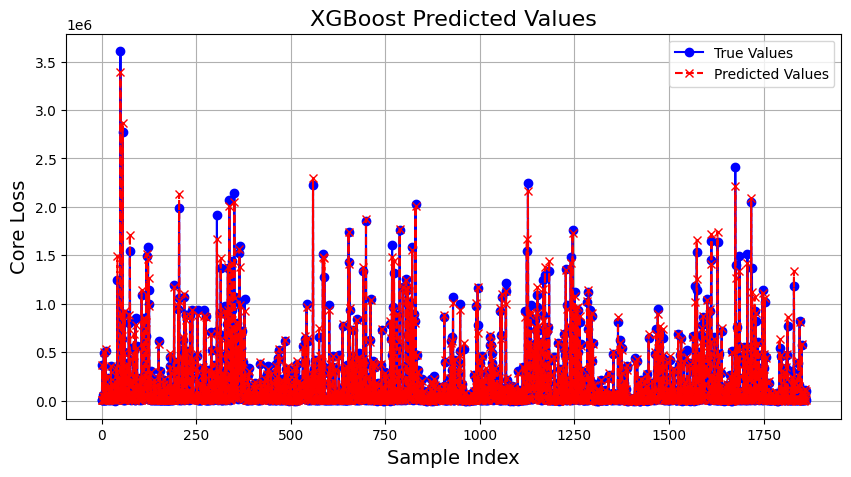

In [45]:
y_pred = model.predict(dtest)
c_loss_test = np.array(c_loss_test) 

plt.figure(figsize=(10, 5))

plt.plot(c_loss_test, label='True Values', marker='o', linestyle='-', color='blue') 
plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')  

plt.title('XGBoost Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Core Loss', fontsize=14)

plt.legend()
plt.grid(True)
plt.show()

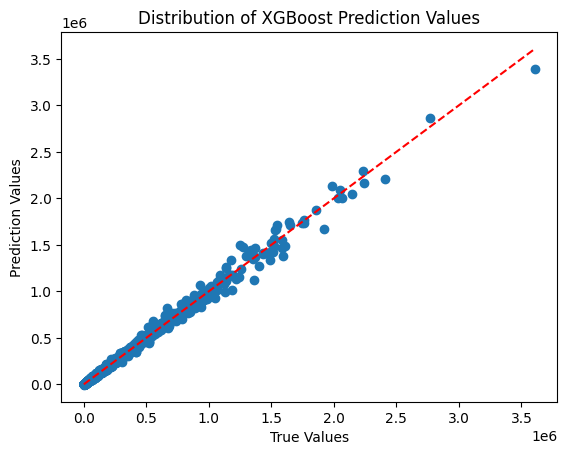

In [46]:
plt.scatter(c_loss_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Prediction Values')
plt.title('Distribution of XGBoost Prediction Values')
plt.plot([c_loss_test.min(), c_loss_test.max()], [c_loss_test.min(), c_loss_test.max()], 'r--')
plt.show()

In [47]:
mse = mean_squared_error(c_loss_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(c_loss_test, y_pred)
mape = np.mean(np.abs((c_loss_test-y_pred) / c_loss_test)) * 100
mae = mean_absolute_error(c_loss_test, y_pred)

print(f'XGBoost MAPE: {mape:.2f}%')
print(f'Mean Squared Error (MSE): {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared (R²): {r2}')

XGBoost MAPE: 10.10%
Mean Squared Error (MSE): 646750677.7906317
RMSE: 25431.293277980018
MAE: 10012.798708626846
R-squared (R²): 0.9944881644841272


In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [50]:
model_f = RandomForestRegressor(n_estimators=100, random_state=42)

In [51]:
model_f.fit(features, c_loss_train)

RandomForestRegressor(random_state=42)

In [52]:
y_pred_rf = model_f.predict(features3)

mse = mean_squared_error(c_loss_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(c_loss_test, y_pred_rf)
mape = np.mean(np.abs((c_loss_test-y_pred_rf) / c_loss_test)) * 100
mae = mean_absolute_error(c_loss_test, y_pred_rf)

print(f'RF MAPE: {mape:.2f}%')
print(f'Mean Squared Error (MSE): {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared (R²): {r2}')

RF MAPE: 10.89%
Mean Squared Error (MSE): 2261992559.7628503
RMSE: 47560.409583632165
MAE: 18916.069261071756
R-squared (R²): 0.9807225081384812


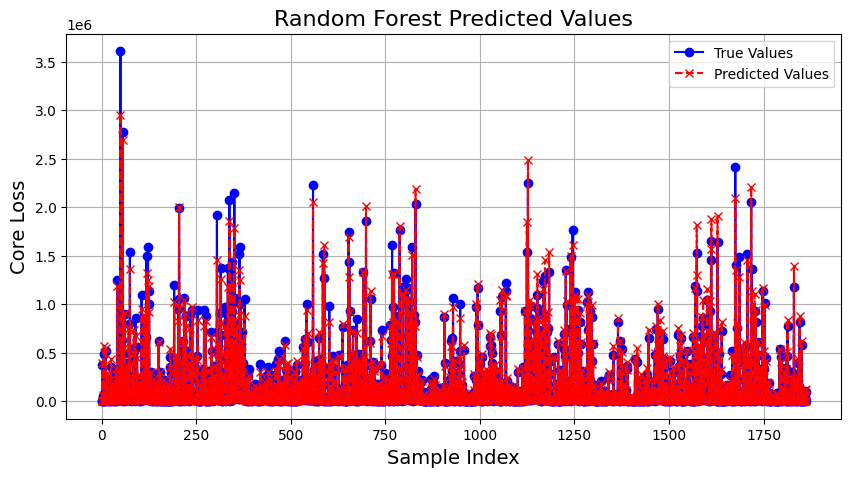

In [53]:
plt.figure(figsize=(10, 5))

plt.plot(c_loss_test, label='True Values', marker='o', linestyle='-', color='blue')  
plt.plot(y_pred_rf, label='Predicted Values', marker='x', linestyle='--', color='red')  

plt.title('Random Forest Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Core Loss', fontsize=14)

plt.legend()
plt.grid(True)
plt.show()

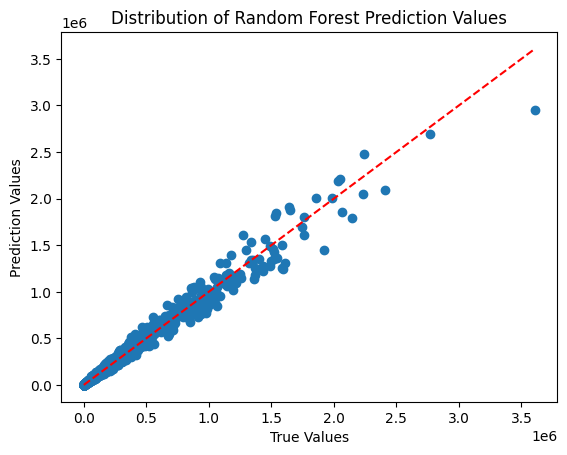

In [54]:
plt.scatter(c_loss_test, y_pred_rf)
plt.xlabel('True Values')
plt.ylabel('Prediction Values')
plt.title('Distribution of Random Forest Prediction Values')
plt.plot([c_loss_test.min(), c_loss_test.max()], [c_loss_test.min(), c_loss_test.max()], 'r--')
plt.show()

In [56]:
class MixedNN(torch.nn.Module):
    def __init__(self):
        super(MixedNN, self).__init__()
        
        self.material_embedding = nn.Embedding(4, 4)  
        self.wavetype_embedding = nn.Embedding(3, 3)  
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv_output_size = 32 * (1024 // 4)  

        self.fc1 = nn.Linear(self.conv_output_size + 4 + 3 + 2, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, material, temperature, fre, wave, wavetype):
        material_embedded = self.material_embedding(material)
        wavetype_embedded = self.wavetype_embedding(wavetype)
        
        wave = wave.unsqueeze(1) 
        wave = self.pool(torch.relu(self.conv1(wave)))
        wave = self.pool(torch.relu(self.conv2(wave)))
        wave = wave.view(wave.size(0), -1)  

        x = torch.cat([wave, material_embedded, wavetype_embedded, temperature, fre], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)  
        return output

In [57]:
class HybridModel(torch.nn.Module):
    def __init__(self, input_size, wave_hidden_size, output_size=1):
        super(HybridModel, self).__init__()
        self.fc_discrete = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.lstm = nn.LSTM(input_size=1024, hidden_size=wave_hidden_size, num_layers=2, batch_first=True)
        self.fc_final = nn.Sequential(
            nn.Linear(wave_hidden_size + 64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_size)
        )

    def forward(self, x_discrete, x_wave):
        discrete_out = self.fc_discrete(x_discrete)
        lstm_out, _ = self.lstm(x_wave)  
        lstm_out = lstm_out[:, -1, :]  
        
        combined = torch.cat((discrete_out, lstm_out), dim=1)
        output = self.fc_final(combined)
        return output

In [58]:
MNN = torch.load('MNN.pth')
LSTM = torch.load('LSTM.pth')

C:\Users\12279\AppData\Local\Temp\ipykernel_14740\3108859521.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  MNN = torch.load('MNN.pth')
C:\Users\12279\AppData\Local\Tem

In [59]:
file_path = 'test_set.xlsx'
data_test = pd.read_excel(file_path)

wave_test = data_test.iloc[:, 5:1029].values 
temperature_test = data_test['temperature,oc'].values
fre_test = data_test['frequency,Hz'].values
c_loss_test = data_test['core loss,w/m3'].values
material_test = data_test['material type'].values
wavetype_test = data_test['excitation waveform'].values

scaler = StandardScaler()
temperature_test_scaled = scaler.fit_transform(temperature_test.reshape(-1, 1))
fre_test_scaled = scaler.fit_transform(fre_test.reshape(-1, 1))
temperature_test = torch.tensor(temperature_test_scaled, dtype=torch.float32)
fre_test = torch.tensor(fre_test_scaled, dtype=torch.float32)
wave_test = torch.tensor(wave_test, dtype=torch.float32)
material_test = torch.tensor(material_test-1, dtype=torch.long)
wavetype_test = torch.tensor(wavetype_test-1, dtype=torch.long)
c_loss_test = torch.tensor(c_loss_test, dtype=torch.float32)

encoder = OneHotEncoder(sparse_output=False) 

encoded_material_test = encoder.fit_transform(material_test.reshape(-1, 1))
encoded_wavetype_test = encoder.fit_transform(wavetype_test.reshape(-1, 1))

features_test = np.concatenate((temperature_test.reshape(-1, 1), 
                                fre_test.reshape(-1, 1), 
                                encoded_material_test, 
                                encoded_wavetype_test), axis=1)

test_tensor = torch.FloatTensor(features_test)
wave_test_tensor = torch.FloatTensor(wave_test).unsqueeze(1)

In [60]:
class CoreLossDataset(Dataset):
    def __init__(self, temperature, fre, material, wavetype, wave, c_loss):
        self.material = material
        self.fre = fre
        self.temperature = temperature
        self.wavetype = wavetype
        self.wave = wave
        self.c_loss = c_loss

    def __len__(self):
        return len(self.c_loss)

    def __getitem__(self, idx):
        return (self.material[idx], 
                self.temperature[idx], 
                self.fre[idx], 
                self.wave[idx], 
                self.wavetype[idx], 
                self.c_loss[idx])

dataset_test = CoreLossDataset(temperature_test, fre_test, material_test, wavetype_test, wave_test, c_loss_test)

In [61]:
MNN.eval()
LSTM.eval()

def compare_predictions(dataset, model):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    output_MNN = []

    with torch.no_grad(): 
        for temperature, fre, material, wavetype, wave, c_loss in dataloader:
            output = model(temperature, fre, material, wavetype, wave).numpy() 
            output_MNN.append(output)
    return output_MNN
    
output_MNN = compare_predictions(dataset_test, MNN)

with torch.no_grad():  
    output_LSTM = LSTM(test_tensor, wave_test_tensor).numpy() 

In [62]:
p_actual = np.array([c_loss_test]).flatten()
p_pred_1 = np.array([y_pred_rf]).flatten()
p_pred_2 = np.array([y_pred]).flatten()
p_pred_3 = np.array([output_MNN]).flatten()
p_pred_4 = np.array([output_LSTM]).flatten()

def mse_loss(weights):
    w1, w2 = weights
    p_combined = w1 * p_pred_2 + w2 * p_pred_3 
    mse = np.mean((p_combined - p_actual) ** 2)
    return mse

constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}

initial_weights = [0.4764, 0.5236]
result = minimize(mse_loss, initial_weights, constraints=constraints)

optimal_weights = result.x
w1=optimal_weights[0]
w2=optimal_weights[1]
print(optimal_weights)

print(f"Optimal weights: w1 = {optimal_weights[0]}, w2 = {optimal_weights[1]}")
print(f"Minimum MSE: {result.fun}")
r2 = r2_score(p_actual, w1 * p_pred_2 + w2 * p_pred_3)
print(f"R²: {r2}")

mape = np.mean(np.abs((p_actual - (w1 * p_pred_2 + w2 * p_pred_3)) / p_actual)) * 100
print(f'MAPE: {mape:.2f}%')

[ 1.5023097 -0.5023097]
Optimal weights: w1 = 1.5023096976653485, w2 = -0.502309697665349
Minimum MSE: 1533911296.0
R²: 0.9869274497032166
MAPE: 18.45%


In [63]:
best_mse = float('inf')
best_w1 = 0
best_w2 = 0

for w1 in np.arange(0, 1.0001, 0.0001):
    w2 = 1 - w1  # 保证 w1 + w2 = 1
    p_combined = w1 * p_pred_2 + w2 * p_pred_3
    mse = mean_squared_error(p_actual, p_combined)
    
    if mse < best_mse:
        best_mse = mse
        best_w1 = w1
        best_w2 = w2

print(f"Best weights: w1 = {best_w1}, w2 = {best_w2}")
print(f"Best MSE: {best_mse}")
p_combined_optimal = best_w1 * p_pred_2 + best_w2 * p_pred_3
r2 = r2_score(p_actual, p_combined_optimal)
print(f"R²: {r2}")
mape = np.mean(np.abs((p_actual - (best_w1 * p_pred_2 + best_w2 * p_pred_3)) / p_actual)) * 100
print(f'MAPE: {mape:.2f}%')
mae = mean_absolute_error(p_actual, best_w1 * p_pred_2 + best_w2 * p_pred_3)
print(mae)

Best weights: w1 = 0.47640000000000005, w2 = 0.5236
Best MSE: 334314144.0
R²: 0.9971508383750916
MAPE: 12.09%
8149.8984


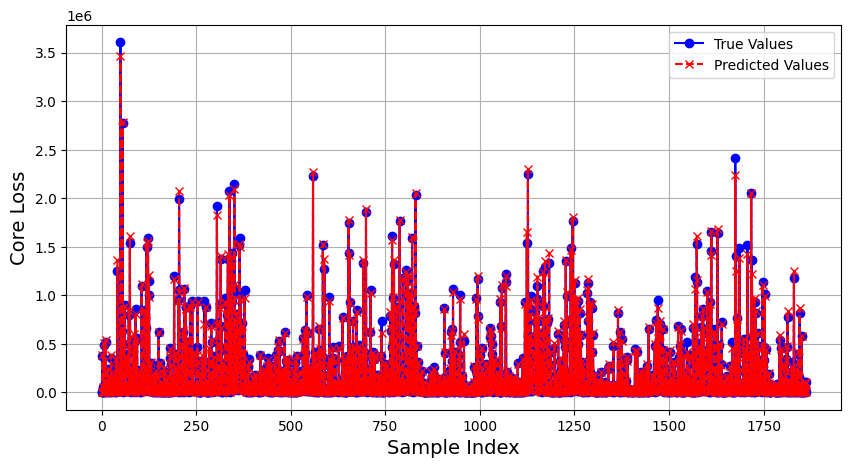

In [64]:
plt.figure(figsize=(10, 5))

plt.plot(p_actual, label='True Values', marker='o', linestyle='-', color='blue') 
plt.plot((best_w1 * p_pred_2 + best_w2 * p_pred_3), label='Predicted Values', marker='x', linestyle='--', color='red')

#plt.title('Weighted model Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Core Loss', fontsize=14)

plt.legend()
plt.grid(True)
plt.savefig('ieee12', bbox_inches='tight', dpi=300)
plt.show()

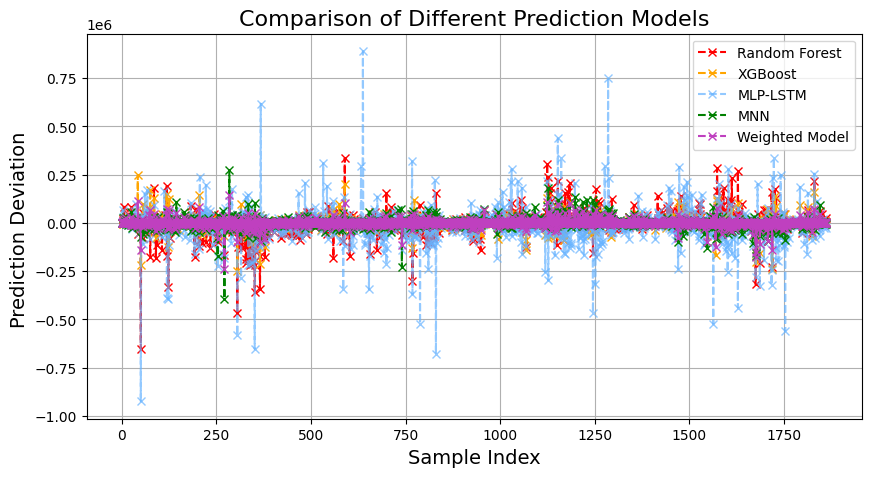

In [65]:
plt.figure(figsize=(10, 5))

plt.plot(p_pred_1-p_actual, label='Random Forest', marker='x', linestyle='--', color='red')
plt.plot(p_pred_2-p_actual, label='XGBoost', marker='x', linestyle='--', color='orange') 
plt.plot(p_pred_4-p_actual, label='MLP-LSTM', marker='x', linestyle='--', color=(0.4, 0.7, 1.0),alpha=0.7) 
plt.plot(p_pred_3-p_actual, label='MNN', marker='x', linestyle='--', color='green')
plt.plot((best_w1 * p_pred_2 + best_w2 * p_pred_3)-p_actual, label='Weighted Model', marker='x', color='#BF40BF',linestyle='--') 

plt.title('Comparison of Different Prediction Models', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Prediction Deviation ', fontsize=14)

plt.legend()
plt.grid(True)
plt.savefig('ieee11', bbox_inches='tight', dpi=300)
plt.show()

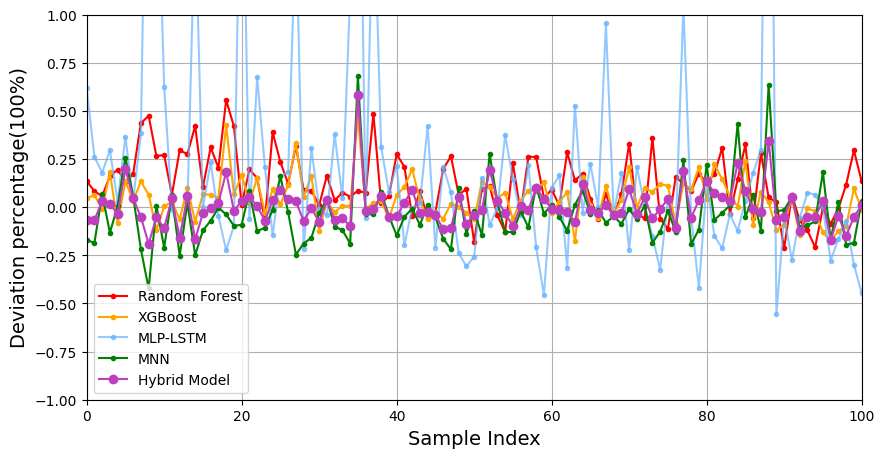

In [71]:
plt.figure(figsize=(10, 5))
plt.plot((p_pred_1-p_actual)/p_actual, label='Random Forest', marker='.', linestyle='-',color='red')
plt.plot((p_pred_2-p_actual)/p_actual, label='XGBoost', marker='.', linestyle='-',color='orange')
plt.plot((p_pred_4-p_actual)/p_actual, label='MLP-LSTM', marker='.', linestyle='-',color=(0.4, 0.7, 1.0),alpha=0.7) 
plt.plot((p_pred_3-p_actual)/p_actual, label='MNN', marker='.', linestyle='-',color='green') 
plt.plot(((best_w1 * p_pred_2 + best_w2 * p_pred_3)-p_actual)/p_actual, label='Hybrid Model', marker='o', color='#BF40BF',linestyle='-') 

#plt.title('Comparison of Different Prediction Models', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Deviation percentage(100%)', fontsize=14)

plt.ylim(-1, 1)
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.savefig('ieee10', bbox_inches='tight', dpi=300)
plt.show()

In [73]:
bins = np.linspace(0, 100, 50)

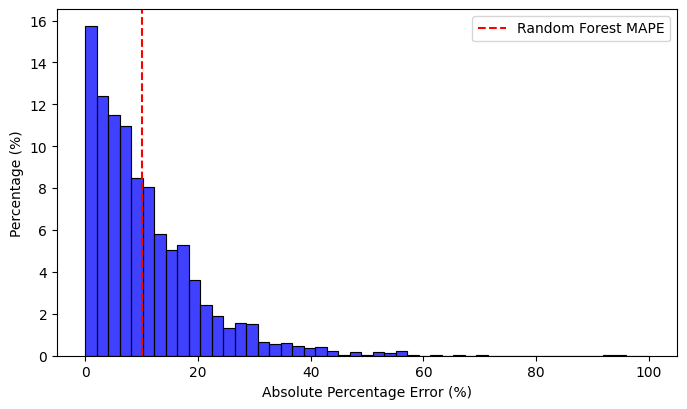

In [107]:
residuals = np.array(p_actual) - p_pred_1
percentage_errors = np.abs((residuals / np.array(p_actual)) * 100)
plt.figure(figsize=(8, 4.5))
sns.histplot(percentage_errors, bins=bins, color='blue', stat='percent', edgecolor='black')
#plt.title('Histogram of Absolute Errors (Percentage)')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Percentage (%)')
plt.axvline(10.10, color='red', linestyle='--', label='Random Forest MAPE')  
plt.legend()
plt.savefig('ieee1', bbox_inches='tight', dpi=300)
plt.show()

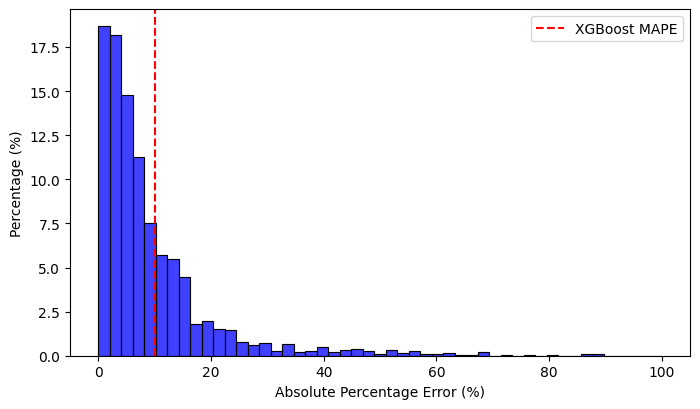

In [109]:
residuals = np.array(p_actual) - p_pred_2
percentage_errors = np.abs((residuals / np.array(p_actual)) * 100)
plt.figure(figsize=(8, 4.5))
sns.histplot(percentage_errors, bins=bins, color='blue', stat='percent', edgecolor='black')
#plt.title('Histogram of Absolute Errors (Percentage)')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Percentage (%)')
plt.axvline(10.10, color='red', linestyle='--', label='XGBoost MAPE')  
plt.legend()
plt.savefig('ieee2', bbox_inches='tight', dpi=300)
plt.show()

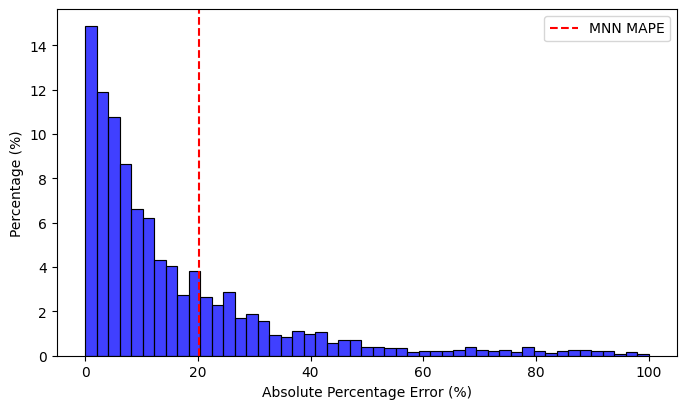

In [101]:
residuals = np.array(p_actual) - p_pred_3
percentage_errors = np.abs((residuals / np.array(p_actual)) * 100)
plt.figure(figsize=(8, 4.5))
sns.histplot(percentage_errors, bins=bins, color='blue', stat='percent', edgecolor='black')
#plt.title('Histogram of Absolute Errors (Percentage)')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Percentage (%)')
plt.axvline(20.25, color='red', linestyle='--', label='MNN MAPE')  
plt.legend()
plt.savefig('ieee3', bbox_inches='tight', dpi=300)
plt.show()

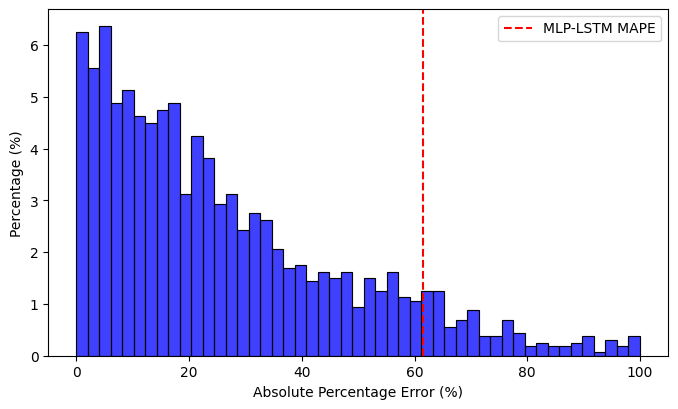

In [102]:
residuals = np.array(p_actual) - p_pred_4
percentage_errors = np.abs((residuals / np.array(p_actual)) * 100)
plt.figure(figsize=(8, 4.5))
sns.histplot(percentage_errors, bins=bins, color='blue', stat='percent', edgecolor='black')
#plt.title('Histogram of Absolute Errors (Percentage)')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Percentage (%)')
plt.axvline(61.46, color='red', linestyle='--', label='MLP-LSTM MAPE')  
plt.legend()
plt.savefig('ieee4', bbox_inches='tight', dpi=300)
plt.show()

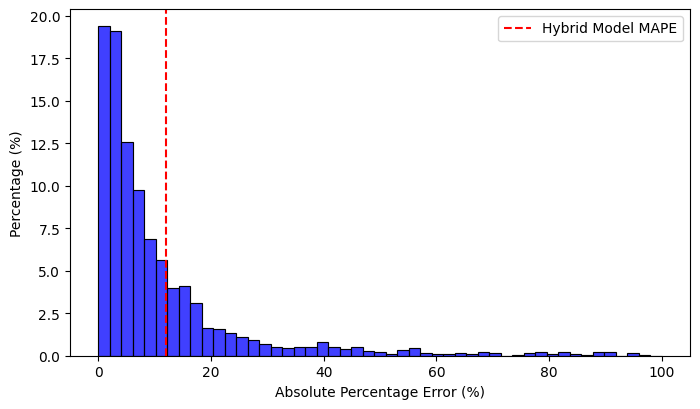

In [104]:
residuals = np.array(p_actual) - (best_w1 * p_pred_2 + best_w2 * p_pred_3)
percentage_errors = np.abs((residuals / np.array(p_actual)) * 100)
plt.figure(figsize=(8, 4.5))
sns.histplot(percentage_errors, bins=bins, color='blue', stat='percent', edgecolor='black')
#plt.title('Histogram of Absolute Errors (Percentage)')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Percentage (%)')
plt.axvline(12.09, color='red', linestyle='--', label='Hybrid Model MAPE') 
plt.legend()
plt.savefig('ieee5', bbox_inches='tight', dpi=300)
plt.show()

In [83]:
def calculate_mape(measured_losses, predicted_losses):
    return np.abs((measured_losses - predicted_losses) / measured_losses) * 100

# 计算每种材料的 MAPE
mape1 = calculate_mape(c_loss_test, p_pred_1)
mape2 = calculate_mape(c_loss_test, p_pred_2)
mape3 = calculate_mape(c_loss_test, p_pred_3)
mape4 = calculate_mape(c_loss_test, p_pred_4)
mape5 = calculate_mape(c_loss_test, (best_w1 * p_pred_2 + best_w2 * p_pred_3))


# 输出最大 MAPE
max_mape1 = np.max(mape1)
max_mape2 = np.max(mape2)
max_mape3 = np.max(mape3)
max_mape4 = np.max(mape4)
max_mape5 = np.max(mape5)

print(f"MAPE1: {max_mape1:.3f}%")
print(f"MAPE2: {max_mape2:.3f}%")
print(f"MAPE3: {max_mape3:.3f}%")
print(f"MAPE4: {max_mape4:.3f}%")
print(f"MAPE5: {max_mape5:.3f}%")

TypeError: max() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: axis, out
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: axis, out


In [ ]:
bins1 = [0, 25, 50, 75, 100, np.inf]
bin_labels = ['0-25%', '25-50%', '50-75%', '75-100%', '>100%']

def calculate_percentages(errors):
    counts, _ = np.histogram(np.abs(errors), bins=bins1)
    percentages = (counts / len(errors)) * 100  
    return percentages

material_1_percentages = calculate_percentages(mape1)
material_2_percentages = calculate_percentages(mape2)
material_3_percentages = calculate_percentages(mape4)
material_4_percentages = calculate_percentages(mape3)
material_5_percentages = calculate_percentages(mape5)

df = pd.DataFrame({
    'Error Range': bin_labels,
    'Random Forest': material_1_percentages,
    'XGBoost': material_2_percentages,
    'MLP-LSTM': material_3_percentages,
    'MNN': material_4_percentages,
    'Hybrid Model': material_5_percentages
})

df_melt = df.melt(id_vars='Error Range', var_name='Model', value_name='Percentage')
plt.figure(figsize=(8,4.5))
sns.barplot(x='Error Range', y='Percentage', hue='Model', data=df_melt)
plt.title('Error Distribution Across Model')
plt.xlabel('Error Range (%)')
plt.ylabel('Percentage (%)')
plt.legend(title='Model')
plt.savefig('ieee6', bbox_inches='tight', dpi=300)
plt.show()